In [1]:
import numpy as np
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import nibabel as nib
import pandas as pd
from IPython.display import clear_output
import importlib
from skimage import morphology
from skimage.segmentation import find_boundaries
import porespy as ps
from skimage.morphology import disk, binary_dilation

In [3]:
ESPECIMEN = "20190404_E2"

In [4]:
cellpose_nu = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/nuclei/{ESPECIMEN}_MASK_EQ_XYZ.nii.gz"
gasp_mem = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/RESULTS/membranes/GASP_PNAS/{ESPECIMEN}_mGFP_CardiacRegion_0.5_XYZ_predictions_GASP.nii.gz"
nuclei = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/CardiacRegion/{ESPECIMEN}/{ESPECIMEN}_DAPI_CardiacRegion_0.5.nii.gz"
mem = f"/Users/dvarelat/Documents/MASTER/TFM/DATA/CardiacRegion/{ESPECIMEN}/{ESPECIMEN}_mGFP_CardiacRegion_0.5.nii.gz"


In [5]:
pred_nu = nib.load(cellpose_nu).get_fdata()
pred_nu.shape

(1020, 764, 432)

In [6]:
pred_mem = nib.load(gasp_mem).get_fdata()
pred_mem.shape

(1020, 764, 432)

In [ ]:
DAPI = nib.load(nuclei).get_fdata()
DAPI = DAPI[:,:,:,0]
DAPI.shape

In [ ]:
MEM = nib.load(mem).get_fdata()
MEM = MEM[:,:,:,0]
MEM.shape

In [ ]:
bound_mem = find_boundaries(pred_mem)

## Solo nuclei dentro del mesodermo

In [8]:
mask_mem = np.where(pred_mem != 0, True, False)

In [9]:
mask_on_nuclei = mask_mem * pred_nu
mask_on_nuclei.shape

(1020, 764, 432)

In [ ]:
n = 200
plt.figure(figsize=(10,10))
plots = [pred_mem[:, :, n], pred_nu[:, :, n],mask_mem[:,:,n],mask_on_nuclei[:,:,n]]
for i in range(len(plots)):
    plt.subplot(1,len(plots), i+1)
    plt.imshow(plots[i])

### Props membranes

In [7]:
img_mem = morphology.label(pred_mem)
props_mem = ps.metrics.regionprops_3D(img_mem)

### Oiginal labels from centroid

In [ ]:
print(len(props_mem))
centroids_mem = [[round(i) for i in p["centroid"]] for p in props_mem]

In [ ]:
original_labels_centroids = [img_mem[c[0],c[1],c[2]] for c in centroids_mem]

### DF and Filtrar por tamaño

In [ ]:
df = pd.DataFrame({"cell_in_props":range(len(props_mem)),
                  "volumes": [p.volume for p in props_mem], 
                  "original_labels":original_labels_centroids, 
                  "centroids":centroids_mem})

In [ ]:
df_clean = df[df.original_labels != 0]
df_clean = df_clean[df_clean.volumes < 1.5*np.median(df_clean.volumes)]
df_clean = df_clean[df_clean.volumes > 0.2*np.median(df_clean.volumes)]
df_clean.describe() 

### Centroid nuclei + original label

In [10]:
img_nu = morphology.label(mask_on_nuclei)
props_nu = ps.metrics.regionprops_3D(img_nu)
centroids_nu = [[round(i) for i in p["centroid"]] for p in props_nu]

In [ ]:
NU_original_labels_centroids = [img_nu[c[0],c[1],c[2]] for c in centroids_nu]

In [ ]:
labels_centroid_nu_in_mem = [img_mem[c[0],c[1],c[2]] for c in centroids_nu]

In [ ]:
dict_nuclei_membrane_centroids = dict(zip(labels_centroid_nu_in_mem, NU_original_labels_centroids))
dict_memlabel_cellnumber_props_nuclei = dict(zip(labels_centroid_nu_in_mem, range(len(centroids_nu))))

In [ ]:
df_clean["nuclei_label_cent"] = [dict_nuclei_membrane_centroids[label] if label in labels_centroid_nu_in_mem else -1 for label in df_clean.original_labels]

In [ ]:
df_clean["nuclei_cell_in_props"] = [dict_memlabel_cellnumber_props_nuclei[label] if label in labels_centroid_nu_in_mem else -1 for label in df_clean.original_labels]

In [ ]:
df_clean[df_clean.nuclei_label_cent == -1]

In [ ]:
for t in range(13):
    plt.figure(figsize=(5,5)) 
    n = 1*t
    plots = [img_mem[props_mem[20].slices][:,:, n], 
             find_boundaries(img_mem[props_mem[20].slices][:,:, n]), 
             centros[props_mem[20].slices][:,:, n]]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

### CHECK PAIR

In [2]:
FILE = "/Users/dvarelat/Documents/MASTER/TFM/DATA/EXTRACTION/20190404_E2/cell_properties.csv"
df = pd.read_csv(FILE)

In [13]:
df.head()

,cell_in_props,volumes,sphericities,original_labels,centroids,lines,axis_major_length,axis_minor_length,volumeRGB,sphericityRGB,nuclei_label_cent,nuclei_cell_in_props
0,0,5453,1.140771,1261.0,"[7, 8, 51]",0.0,28.644782,17.930625,"[0, 26, 229, 255]","[0, 239, 16, 255]",2131.0,0
1,2,2999,0.820548,2312.0,"[11, 4, 73]",0.0,29.557108,12.503101,"[0, 14, 241, 255]","[0, 142, 113, 255]",3228.0,1
2,6,913,1.139358,5276.0,"[4, 2, 114]",0.0,19.986726,8.286374,"[0, 5, 250, 255]","[0, 238, 17, 255]",6235.0,3
3,8,867,0.821385,8820.0,"[2, 12, 202]",0.0,22.803485,6.240074,"[0, 4, 251, 255]","[0, 142, 113, 255]",11377.0,4
4,10,4527,0.882314,5761.0,"[10, 8, 126]",0.0,31.159790,15.027543,"[0, 22, 233, 255]","[0, 161, 94, 255]",7085.0,5


In [11]:
props_nu[0].centroid

(5.463039621525724, 6.887049083382614, 53.27439384979302)

In [22]:
print(props_mem[0].slices)
props_nu[0].slices

(slice(0, 16, None), slice(0, 19, None), slice(38, 65, None))


(slice(0, 13, None), slice(0, 17, None), slice(48, 60, None))

In [14]:
df[df.cell_in_props == 0]

,cell_in_props,volumes,sphericities,original_labels,centroids,lines,axis_major_length,axis_minor_length,volumeRGB,sphericityRGB,nuclei_label_cent,nuclei_cell_in_props
0,0,5453,1.140771,1261.0,"[7, 8, 51]",0.0,28.644782,17.930625,"[0, 26, 229, 255]","[0, 239, 16, 255]",2131.0,0


In [15]:
test = np.zeros(img_mem.shape)
test[6, 7, 53] = 1

In [16]:
test = binary_dilation(test, morphology.ball(radius=4)) 

In [ ]:
x = np.where(pred_mem == 1, 0, 1)

In [29]:
test[props_nu[0].slices].shape

(13, 17, 12)

In [23]:
np.unique(test[props_mem[0].slices])

array([False,  True])

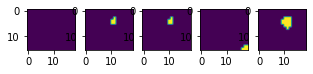

In [36]:
for t in range(27):
    plt.figure(figsize=(5,5)) 
    n = 1*t
    plots = [test[props_mem[0].slices][:,:, n], 
             props_mem[0].border[:,:, n],
             props_mem[0].image[:,:, n],
            pred_nu[props_mem[0].slices][:,:, n],
             props_mem[0].image_convex[:,:, n]
            ]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)

In [47]:
props_nu[0].image.shape

(13, 17, 12)

In [58]:
from numpy import linalg as LA
props_mem[0].inertia_tensor_eigvals

[64.82689141304941, 57.10154244909198, 39.87607983742602]

## VER: binary - nuclei centroid + border

In [ ]:
centros = np.zeros(img_nu.shape)
for i,c in enumerate(centroids_nu):
    centros[c[0],c[1], c[2]] = 1
centros = binary_dilation(centros, morphology.ball(radius=4)) 

In [ ]:
for t in range(24):
    plt.figure(figsize=(10,10)) 
    n = 100 #20*t
    plots = [centros[:, :, n] + bound_mem[:, :, n] ]
    for i in range(len(plots)):
        plt.subplot(1,len(plots), i+1)
        plt.imshow(plots[i])
    plt.show()
    clear_output(wait=True)
    break